In [12]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.


In [13]:
!chmod 600 ~/.kaggle/kaggle.json

'chmod' is not recognized as an internal or external command,
operable program or batch file.


In [22]:
import kagglehub
import os

download_path = "../data"
os.makedirs(download_path, exist_ok=True)
path = kagglehub.dataset_download("rohanrao/air-quality-data-in-india")
os.rename(path, os.path.join(download_path, os.path.basename(path)))
print("Path to dataset files:", os.path.join(download_path, os.path.basename(path)))


Path to dataset files: ../data\12


In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
np.random.seed(7)
%matplotlib inline

In [23]:
df = pd.read_csv('../data/12/city_day.csv', low_memory = False, parse_dates=['Date'])

In [24]:
df = df.drop(labels=['NO', 'NOx', 'NH3', 'Benzene', 'Toluene', 'Xylene'], axis = 1)

In [25]:
df.describe()

,Date,PM2.5,PM10,NO2,CO,SO2,O3,AQI
count,29531,24933.000000,18391.000000,25946.000000,27472.000000,25677.000000,25509.000000,24850.000000
mean,2018-05-14 05:40:15.807118080,67.450578,118.127103,28.560659,2.248598,14.531977,34.491430,166.463581
min,2015-01-01 00:00:00,0.040000,0.010000,0.010000,0.000000,0.010000,0.010000,13.000000
25%,2017-04-16 00:00:00,28.820000,56.255000,11.750000,0.510000,5.670000,18.860000,81.000000
50%,2018-08-05 00:00:00,48.570000,95.680000,21.690000,0.890000,9.160000,30.840000,118.000000
75%,2019-09-03 00:00:00,80.590000,149.745000,37.620000,1.450000,15.220000,45.570000,208.000000
max,2020-07-01 00:00:00,949.990000,1000.000000,362.210000,175.810000,193.860000,257.730000,2049.000000
std,NaN,64.661449,90.605110,24.474746,6.962884,18.133775,21.694928,140.696585


In [26]:
df.head()

,City,Date,PM2.5,PM10,NO2,CO,SO2,O3,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,18.22,0.92,27.64,133.36,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,15.69,0.97,24.55,34.06,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,19.30,17.40,29.07,30.70,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,18.48,1.70,18.59,36.08,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,21.42,22.10,39.33,39.31,NaN,NaN


## Data Cleaning

In [27]:
# Drop City, Date, AQI_Bucket
df = df.drop(labels = ['AQI_Bucket'], axis = 1)

In [28]:
df1 = df[['City', 'Date', 'AQI', 'PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3']].copy()
columns_to_interpolate = ['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3']
df1.sort_values(by=['City', 'Date'], inplace=True)
df1[columns_to_interpolate] = df1.groupby('City')[columns_to_interpolate].apply(lambda group: group.interpolate(method='linear', limit_direction='both')).reset_index(drop=True) # Reset index after groupby

In [29]:
df1.isna().sum()

City        0
Date        0
AQI      4681
PM2.5       0
PM10     2009
NO2         0
CO          0
SO2         0
O3        162
dtype: int64

In [30]:
col = df.columns.to_list()
col.remove('AQI')
col.remove('City')
col.remove('Date')

In [31]:
def subplot_features(col=col, df=df):
    fig, ax = plt.subplots(len(col)//2, 2, figsize=(12, 12));

    for i, x in enumerate(col, start = 0):
        ax[i//2, i%2].scatter(df[x], df['AQI'])
        ax[i//2, i%2].title.set_text(f"{x} vs AQI")

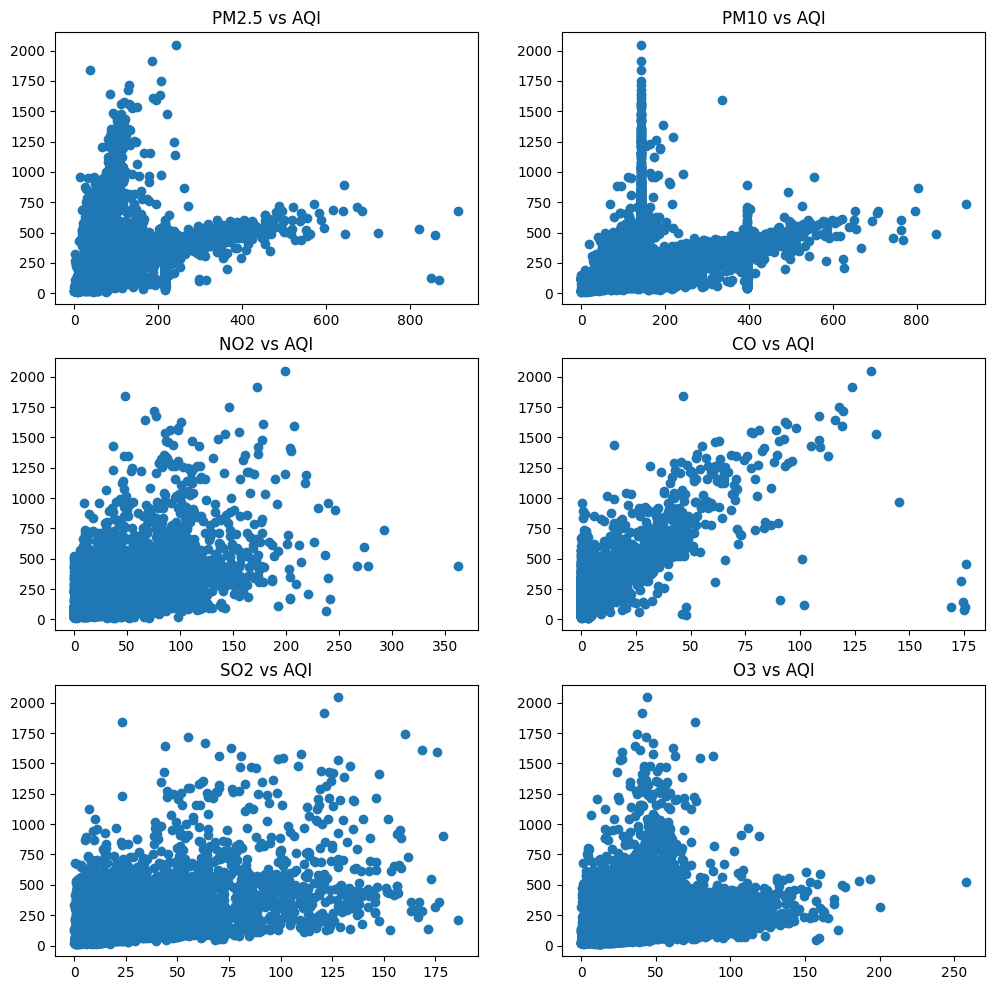

In [32]:
subplot_features(df=df1);

In [33]:
df1 = df1.dropna(subset=['AQI'])

In [34]:
df1.isna().sum()

City        0
Date        0
AQI         0
PM2.5       0
PM10     1893
NO2         0
CO          0
SO2         0
O3        153
dtype: int64

In [35]:
df1[df1.isna().any(axis=1)]['City'].unique()

array(['Ernakulam', 'Lucknow'], dtype=object)

In [36]:
df1 = df1.dropna(subset=['PM10', 'O3'])

In [37]:
df1.isna().sum()

City     0
Date     0
AQI      0
PM2.5    0
PM10     0
NO2      0
CO       0
SO2      0
O3       0
dtype: int64

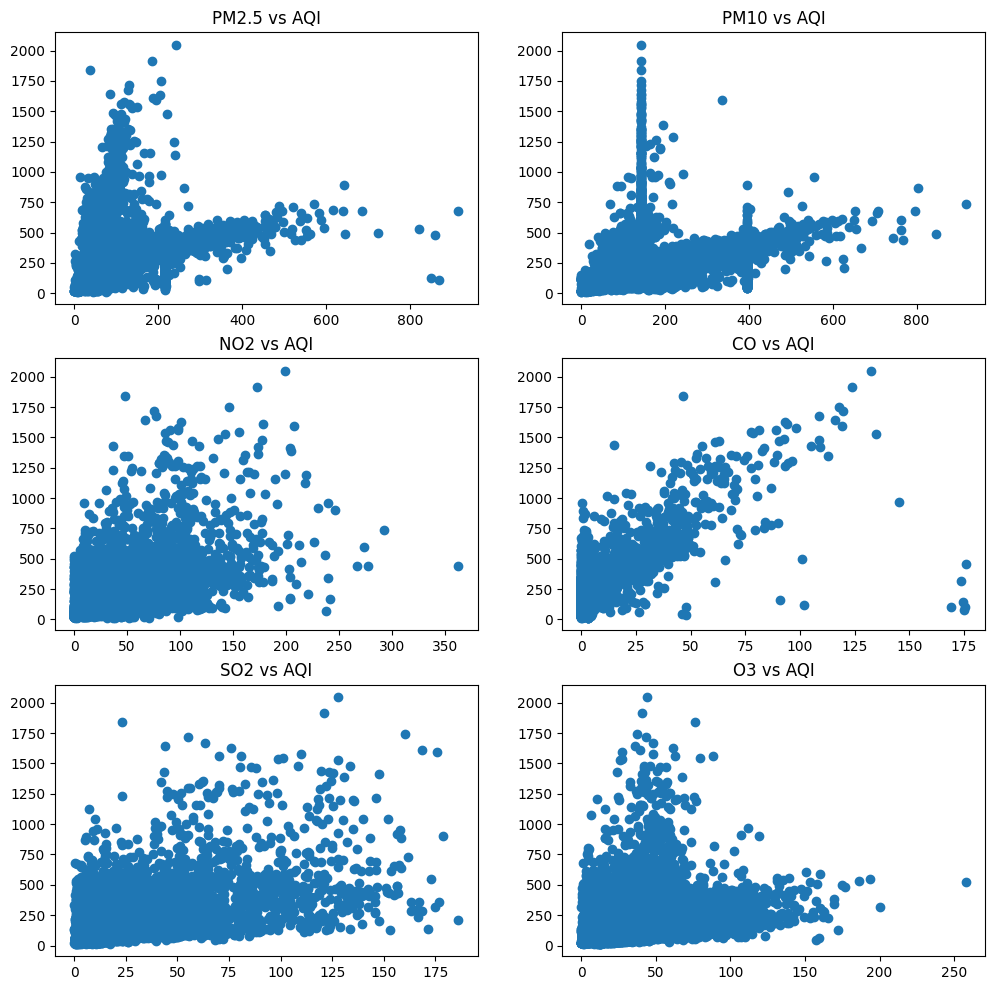

In [38]:
subplot_features(df=df1)

In [39]:
def remove_outlier_IQR(df, col):
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - (1.5 * IQR)
  upper_bound = Q3 + (1.5 * IQR)
  df_out = df.loc[(df[col] > lower_bound) & (df[col] < upper_bound)]
  return df_out

for column in col:
  df1 = remove_outlier_IQR(df1, column)

df1.shape


(15939, 9)

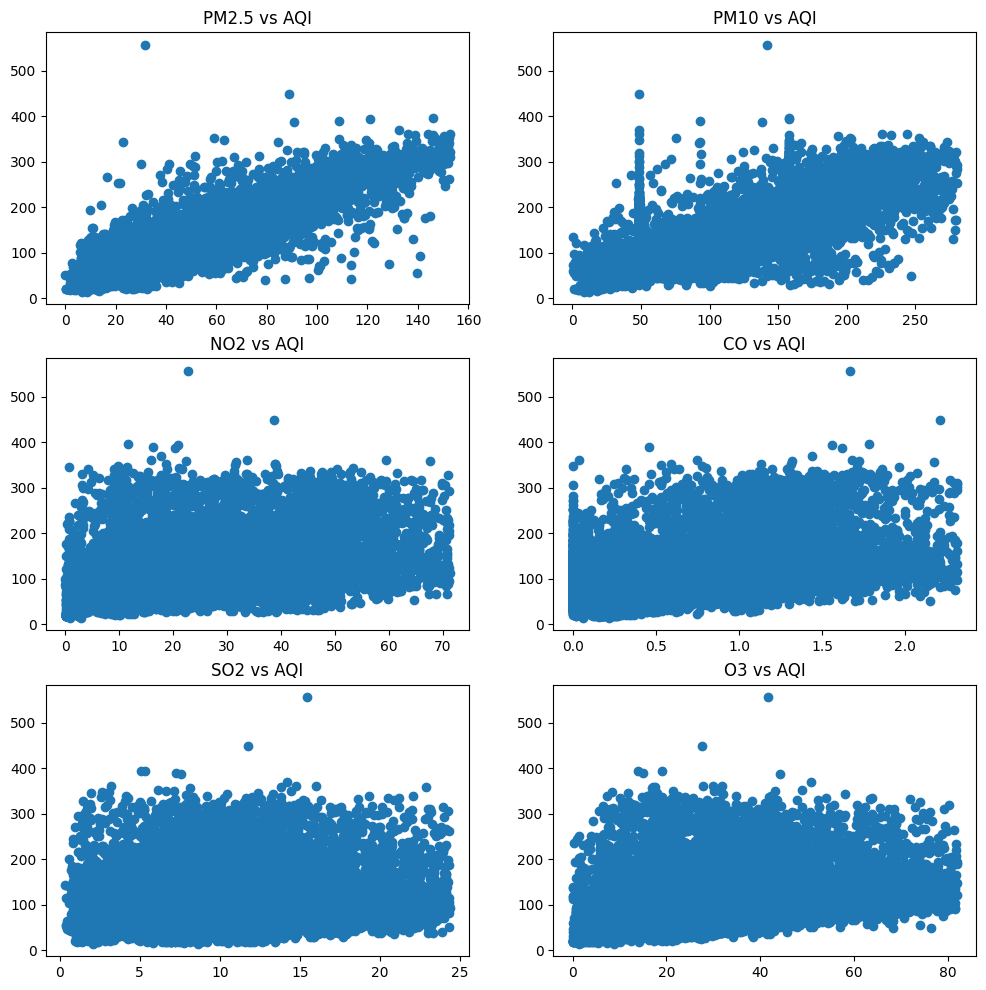

In [40]:
subplot_features(df=df1)

## Model Training and Experimentation

In [41]:
df1.to_csv('../data/city-aqi-reduced.csv', index = False)

In [42]:
df1 = pd.read_csv('../data/city-aqi-reduced.csv', low_memory = False)

In [26]:
X = df1.drop(labels = ['City', 'Date', 'AQI'], axis = 1)
y = df1['AQI']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12751, 6), (3188, 6), (12751,), (3188,))

In [27]:
es_1 = tf.keras.callbacks.EarlyStopping(
    monitor='root_mean_squared_error',
    patience=2,
    verbose=1,
)

In [28]:
history_li = list()
color_li = list()

In [29]:
from types import LambdaType
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot

def model_plot(y_test, y_preds, history_li=history_li, colors=color_li):
    fig, ax = plt.subplots(3, 2, figsize=(12, 12))  # Create a 2x2 grid of subplots

    # Subplot 1: Scatter plot of true vs predicted values
    ax[0, 0].scatter(y_test, y_preds, cmap='Blues', alpha=0.5, label='predicted-vs-true')
    ax[0, 0].plot(y_test, y_test, color='red', linestyle='--', label='linear-fit')
    ax[0, 0].set_title('AQI Regression Model')
    ax[0, 0].set_xlabel('True Value')
    ax[0, 0].set_ylabel('Predicted Value')
    ax[0, 0].legend()

    # Subplot 2: KDE plot of true and predicted values distribution
    sns.kdeplot(y_preds, color='blue', fill=True, alpha=0.5,  ax=ax[0, 1], label='predicted')
    sns.kdeplot(y_test, color='red', fill=True, alpha=0.5, ax=ax[0, 1], label='true')
    ax[0, 1].set_title('Values Distribution')
    ax[0, 1].set_xlabel('Continuous Value')
    ax[0, 1].set_ylabel('Density')
    ax[0, 1].legend()

    # Subplot 3: Q-Q plot of error distribution
    residuals = y_test - y_test
    stats.probplot(residuals, dist="norm", plot=ax[1, 0])
    ax[1, 0].set_title("Q-Q Plot")

    # Subplot 4: Residual ranged barplot
    ranges = [(i, i + 25) for i in range(0, 500, 25)]
    means = []
    std_devs = []

    for lower, upper in ranges:
        mask = (y_test >= lower) & (y_test < upper)
        errors = np.abs(y_test[mask] - y_preds[mask])
        means.append(np.mean(errors))
        std_devs.append(np.std(errors))

    ax[1, 1].errorbar([np.mean(r) for r in ranges], means, yerr=std_devs, fmt='o', capsize=5)
    ax[1, 1].set_xlabel('AQI Range')
    ax[1, 1].set_ylabel('Mean Absolute Error')
    ax[1, 1].set_title('Error Bar Plot of Mean Absolute Error by AQI Range')
    ax[1, 1].grid(True)

    # Subplot 5: Model comparison (rmse over epochs)
    ax[2, 0].set_title('Model Comparison')
    ax[2, 0].set_xlabel('Epochs')
    ax[2, 0].set_ylabel('RMSE')
    if history_li and colors:
        for i, history in enumerate(history_li, start=1):
            ax[2, 0].plot(history.history['root_mean_squared_error'], color=colors[i-1], label=f"Model-{i} rmse")
        ax[2, 0].legend()

    # Subplot 6: Model comparison (loss over epochs)
    ax[2, 1].set_title('Model Comparison')
    ax[2, 1].set_xlabel('Epochs')
    ax[2, 1].set_ylabel('Loss')
    if history_li and colors:
        for i, history in enumerate(history_li, start=1):
            ax[2, 1].plot(history.history['loss'], color=colors[i-1], label=f"Model-{i} loss")
        ax[2, 1].legend()

    plt.tight_layout()
    plt.show()

In [30]:
tf.random.set_seed(7)
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu'),
])

model_1.compile(
    loss = tf.keras.losses.mse,
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics = tf.keras.metrics.RootMeanSquaredError()
)

history_1 = model_1.fit(X_train, y_train, epochs = 100, batch_size=32, callbacks=[es_1])
history_li.append(history_1)
color_li.append('magenta')

Epoch 1/100
399/399 [==============================] - 4s 5ms/step - loss: 2810.2947 - root_mean_squared_error: 53.0122
Epoch 2/100
399/399 [==============================] - 1s 4ms/step - loss: 723.8618 - root_mean_squared_error: 26.9047
Epoch 3/100
399/399 [==============================] - 1s 4ms/step - loss: 703.7974 - root_mean_squared_error: 26.5292
Epoch 4/100
399/399 [==============================] - 1s 4ms/step - loss: 686.6407 - root_mean_squared_error: 26.2038
Epoch 5/100
399/399 [==============================] - 1s 3ms/step - loss: 675.6242 - root_mean_squared_error: 25.9928
Epoch 6/100
399/399 [==============================] - 1s 4ms/step - loss: 666.9435 - root_mean_squared_error: 25.8252
Epoch 7/100
399/399 [==============================] - 1s 3ms/step - loss: 675.4957 - root_mean_squared_error: 25.9903
Epoch 8/100
399/399 [==============================] - 1s 3ms/step - loss: 681.0141 - root_mean_squared_error: 26.0962
Epoch 8: early stopping


In [31]:
model_1.evaluate(X_test, y_test)

100/100 [==============================] - 1s 4ms/step - loss: 686.2029 - root_mean_squared_error: 26.1955


[686.2029418945312, 26.195476531982422]

In [32]:
y_preds_1 = model_1.predict(X_test).squeeze()

100/100 [==============================] - 0s 3ms/step


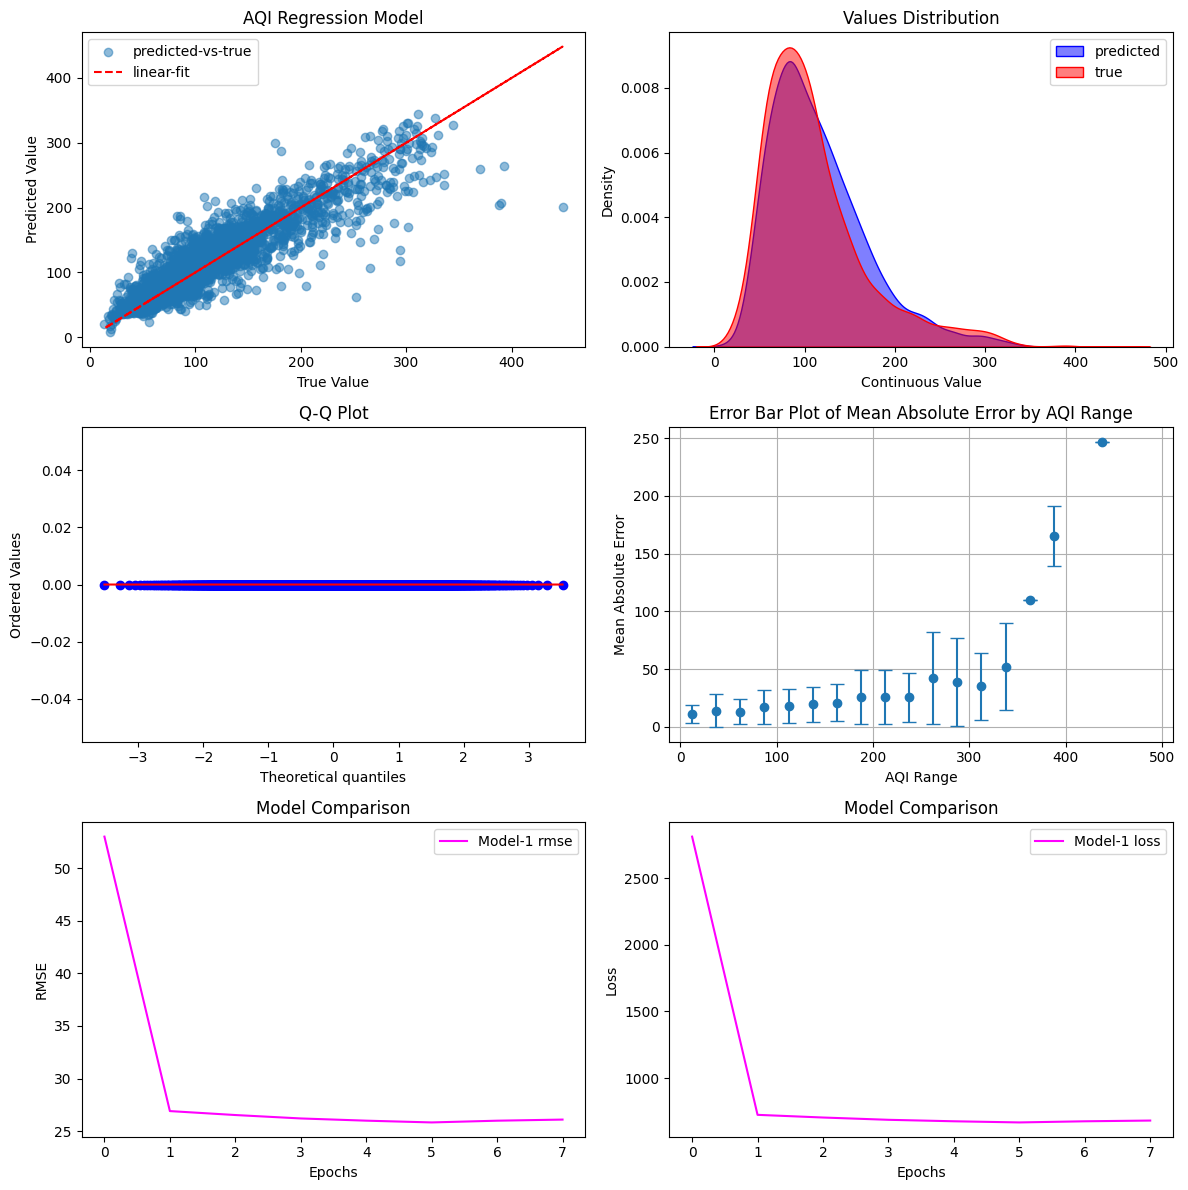

In [33]:
model_plot(y_test, y_preds_1)

In [34]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu'),
])

model_2.compile(
    loss = tf.keras.losses.mse,
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = tf.keras.metrics.RootMeanSquaredError()
)

history_2 = model_2.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[es_1])
history_li.append(history_2)
color_li.append('coral')

Epoch 1/100
399/399 [==============================] - 3s 4ms/step - loss: 4425.1177 - root_mean_squared_error: 66.5216
Epoch 2/100
399/399 [==============================] - 2s 4ms/step - loss: 813.1149 - root_mean_squared_error: 28.5152
Epoch 3/100
399/399 [==============================] - 2s 4ms/step - loss: 727.0380 - root_mean_squared_error: 26.9636
Epoch 4/100
399/399 [==============================] - 2s 5ms/step - loss: 708.1561 - root_mean_squared_error: 26.6112
Epoch 5/100
399/399 [==============================] - 1s 3ms/step - loss: 701.8723 - root_mean_squared_error: 26.4929
Epoch 6/100
399/399 [==============================] - 1s 3ms/step - loss: 695.8731 - root_mean_squared_error: 26.3794
Epoch 7/100
399/399 [==============================] - 1s 3ms/step - loss: 689.9160 - root_mean_squared_error: 26.2663
Epoch 8/100
399/399 [==============================] - 1s 3ms/step - loss: 686.7869 - root_mean_squared_error: 26.2066
Epoch 9/100
399/399 [==========================

In [35]:
model_2.evaluate(X_test, y_test)

100/100 [==============================] - 0s 2ms/step - loss: 668.3759 - root_mean_squared_error: 25.8530


[668.3759155273438, 25.85296630859375]

In [36]:
y_preds_2 = model_2.predict(X_test).squeeze()

100/100 [==============================] - 0s 2ms/step


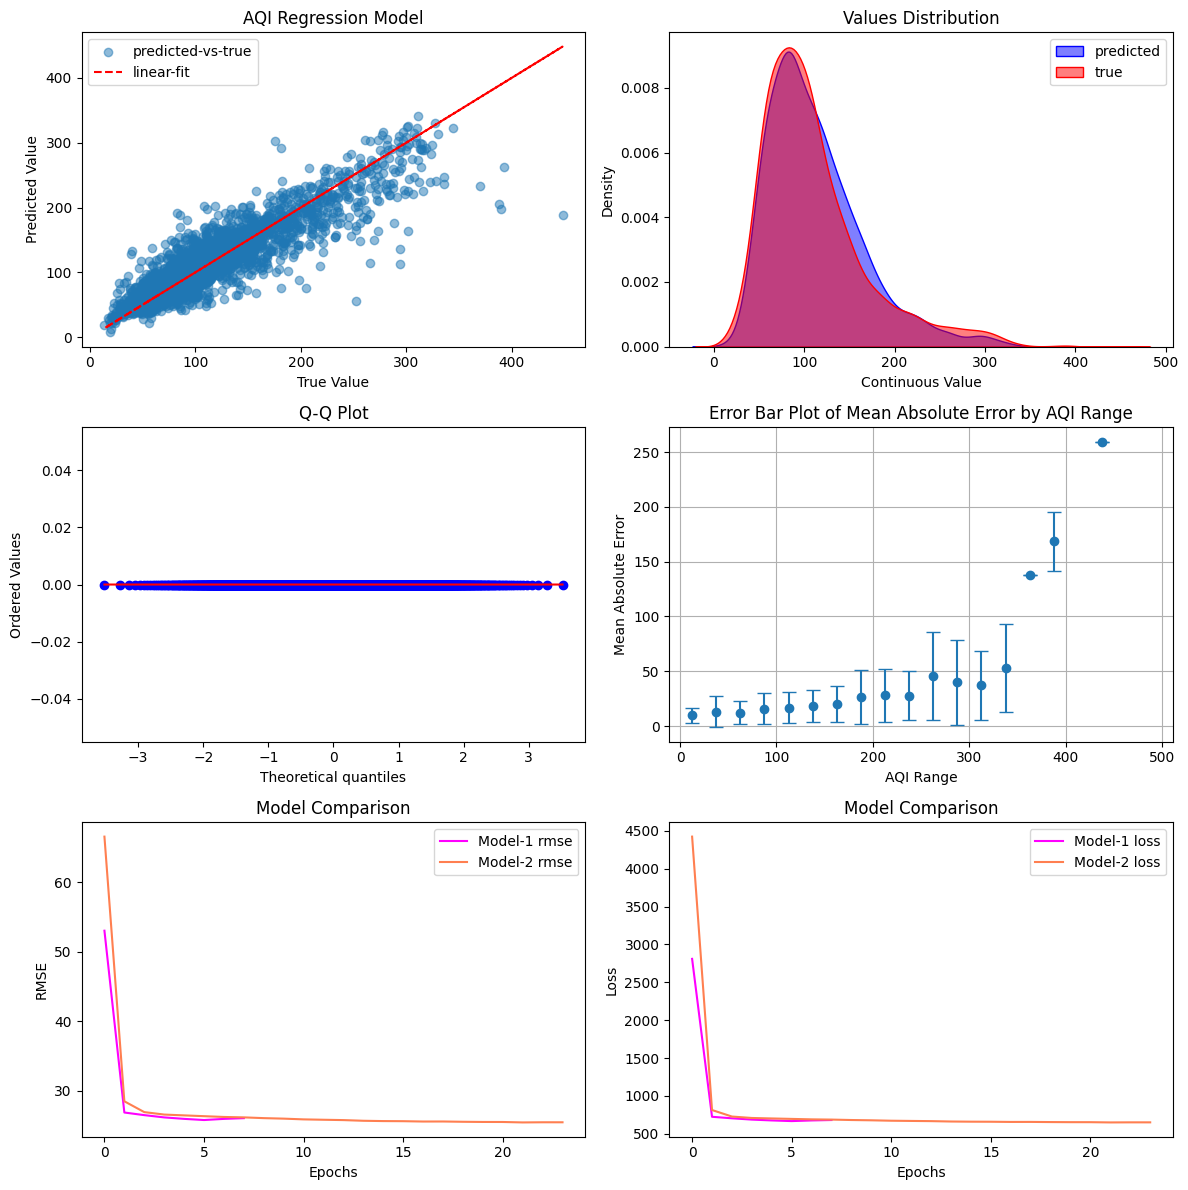

In [37]:
model_plot(y_test, y_preds_2)

In [52]:
es_2 = tf.keras.callbacks.EarlyStopping(
    monitor='root_mean_squared_error',
    patience=3,
    verbose=1
)

In [77]:
tf.random.set_seed(7)
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu'),
])

model_3.compile(
    loss = tf.keras.losses.mse,
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = tf.keras.metrics.RootMeanSquaredError()
)

history_3 = model_3.fit(X_train, y_train, epochs = 100, batch_size=32, callbacks=[es_2])
history_li.append(history_3)
color_li.append('royalblue')

Epoch 1/100
399/399 [==============================] - 2s 2ms/step - loss: 7648.3521 - root_mean_squared_error: 87.4549
Epoch 2/100
399/399 [==============================] - 1s 2ms/step - loss: 979.1326 - root_mean_squared_error: 31.2911
Epoch 3/100
399/399 [==============================] - 1s 3ms/step - loss: 805.3087 - root_mean_squared_error: 28.3780
Epoch 4/100
399/399 [==============================] - 1s 4ms/step - loss: 737.2244 - root_mean_squared_error: 27.1519
Epoch 5/100
399/399 [==============================] - 1s 4ms/step - loss: 723.7478 - root_mean_squared_error: 26.9026
Epoch 6/100
399/399 [==============================] - 2s 4ms/step - loss: 714.7991 - root_mean_squared_error: 26.7357
Epoch 7/100
399/399 [==============================] - 1s 3ms/step - loss: 706.1216 - root_mean_squared_error: 26.5729
Epoch 8/100
399/399 [==============================] - 1s 2ms/step - loss: 700.4153 - root_mean_squared_error: 26.4654
Epoch 9/100
399/399 [==========================

In [78]:
model_3.evaluate(X_test, y_test)

100/100 [==============================] - 0s 2ms/step - loss: 622.1226 - root_mean_squared_error: 24.9424


[622.12255859375, 24.942384719848633]

In [79]:
y_preds_3 = model_3.predict(X_test).squeeze()

100/100 [==============================] - 0s 1ms/step


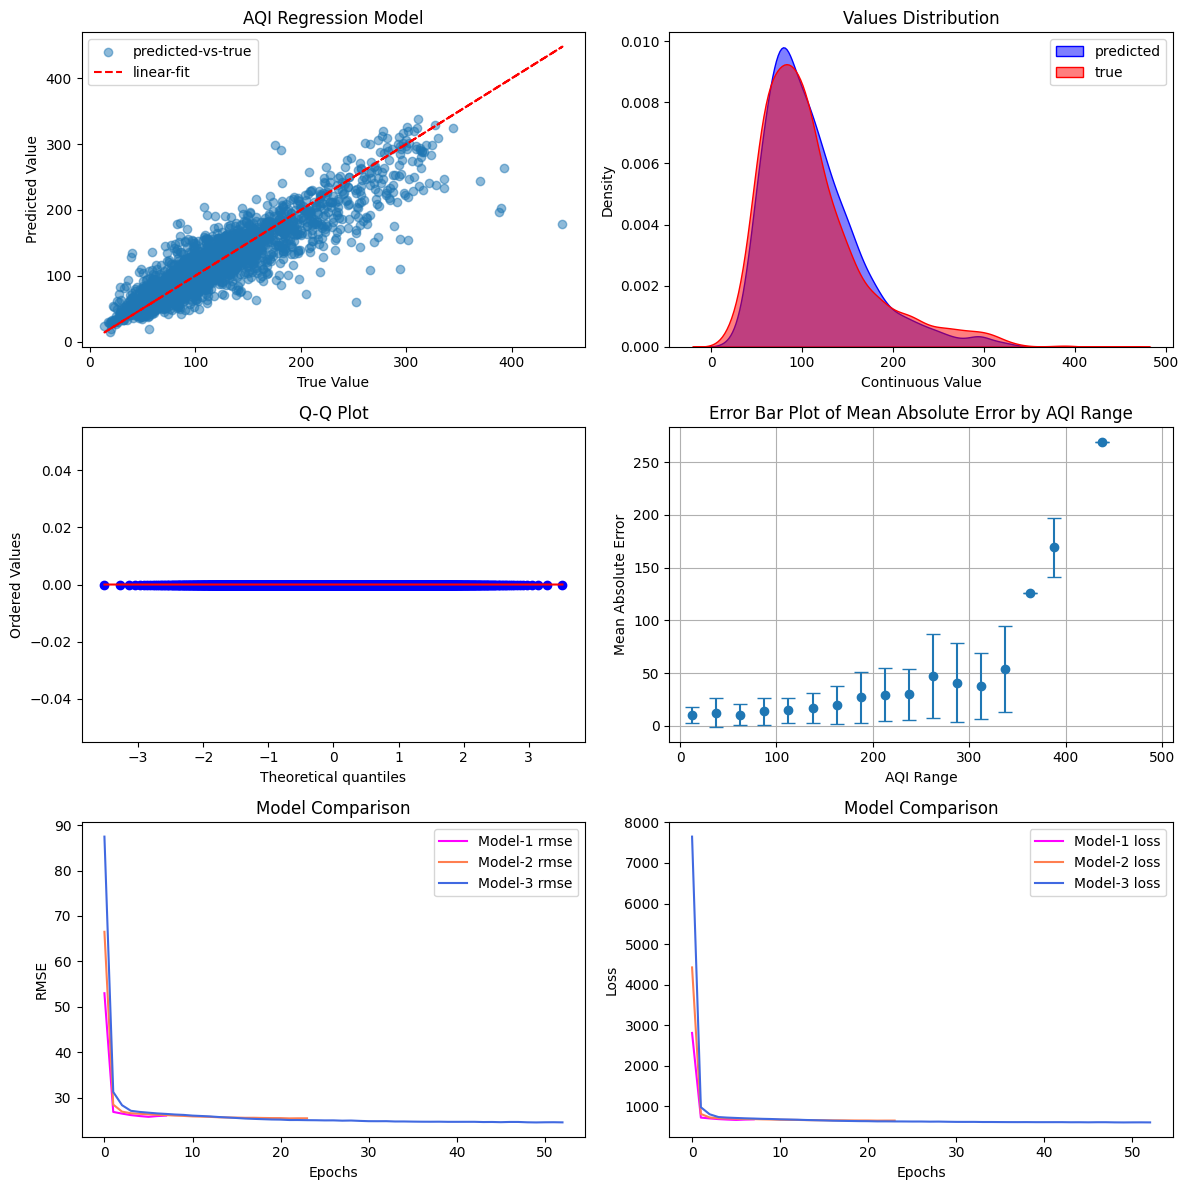

In [83]:
model_plot(y_test, y_preds_3)

## Model Saving and testing
1. After testing model formats like: `${model}.keras`, `${model}.h5`, `${model}(zip)`. `.h5` format models works well with streamlit.
2. Model nomenclature would be based on total_params
3. After model visulization, we'll save the model

In [101]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 42        
                                                                 
 dense_1 (Dense)             (None, 6)                 42        
                                                                 
 dense_2 (Dense)             (None, 1)                 7         
                                                                 
Total params: 91 (364.00 Byte)
Trainable params: 91 (364.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [102]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12)                84        
                                                                 
 dense_4 (Dense)             (None, 6)                 78        
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 169 (676.00 Byte)
Trainable params: 169 (676.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [103]:
model_3.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 12)                84        
                                                                 
 dense_47 (Dense)            (None, 6)                 78        
                                                                 
 dense_48 (Dense)            (None, 3)                 21        
                                                                 
 dense_49 (Dense)            (None, 1)                 4         
                                                                 
Total params: 187 (748.00 Byte)
Trainable params: 187 (748.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [106]:
from tensorflow.keras.utils import plot_model

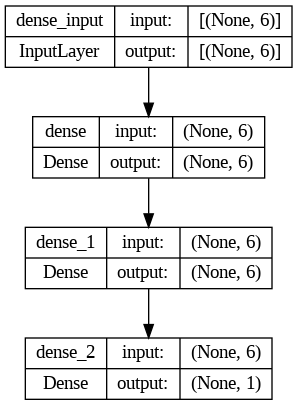

In [107]:
plot_model(model_1, show_shapes=True)

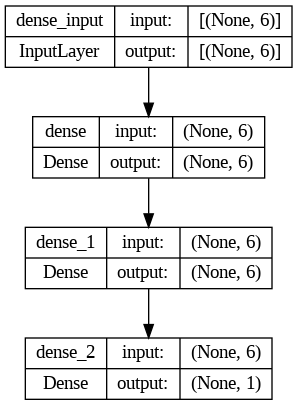

In [108]:
plot_model(model_1, show_shapes=True)

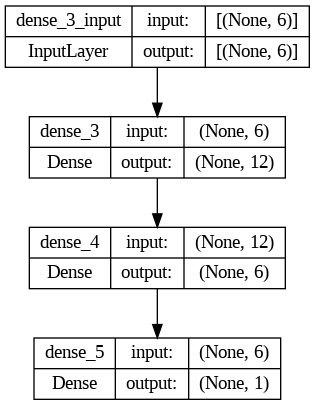

In [110]:
plot_model(model_2, show_shapes=True)

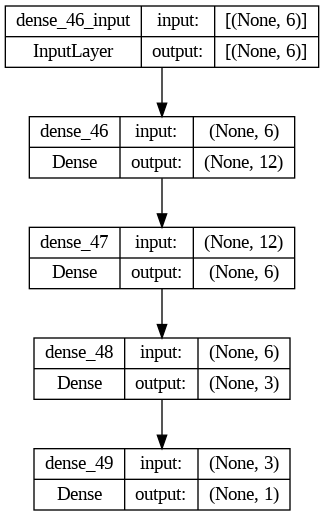

In [111]:
plot_model(model_3, show_shapes=True)

In [113]:
model_1.save('model_91.h5')
model_2.save('model_169.h5')
model_3.save('model_187.h5')